In [1]:
#!pip install shap
!pip install -U git+https://github.com/DataResponsibly/ShaRP.git

  Cloning https://github.com/DataResponsibly/ShaRP.git to /private/var/folders/0m/s1nst3zd2q9_sk0pd7vzbhqc0000gn/T/pip-req-build-lr6_ogcs
  Running command git clone --filter=blob:none --quiet https://github.com/DataResponsibly/ShaRP.git /private/var/folders/0m/s1nst3zd2q9_sk0pd7vzbhqc0000gn/T/pip-req-build-lr6_ogcs
  Resolved https://github.com/DataResponsibly/ShaRP.git to commit d9a0aac700875284b908e63848677adcefa62262
  Preparing metadata (setup.py) ... done

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import io
import requests

from sklearn.model_selection import train_test_split

# import some learn-to-rank method
from sharp import ShaRP
import pandas as pd
import lightgbm as lgb

# utility functions
from sharp.utils import scores_to_ordering
from mlresearch.utils import set_matplotlib_style

set_matplotlib_style(42, **{"font.family":"Times"})

/Users/vp/Documents/GitHub/ShaRP/venv/lib/python3.10/site-packages/mlresearch/utils/_visualization.py:82: UserWarning: Could not find a LaTeX installation. ``text.usetex`` will be set to False.
  warnings.warn(warn_msg)


# Define functions

In [3]:
# def calculate_relevance(ranks):
#     """Converts a rank vector to a relevance score"""
#     relevance_scores = 1 - ranks / ranks.shape[0]
#     return relevance_scores

# data
We use the "movers" data from
Yang, Ke, Joshua R. Loftus, and Julia Stoyanovich. "Causal intersectionality for fair ranking." arXiv preprint arXiv:2006.08688 (2020).

In [4]:
def file_formatting(df):
    df['qid'] = df['qid'].str.replace('qid:', '')
    df['gender'] = df['gender'].str.replace('1:', '')
    df['race'] = df['race'].str.replace('2:', '')
    df['X'] = df['X'].str.replace('3:', '')
    df['Y'] = df['Y'].str.replace('4:', '')
    df = df.astype({'gender': int, 'race': int, 'X': float, 'Y': float})
    print(df.describe())
    return df

def process_file(directory, filenum):
    url="http://raw.githubusercontent.com/DataResponsibly/CIFRank/master/out/ranklib_data/mv/m2/Full"
    file_test = url+'/'+directory+'/'+filenum+'_test_ranklib.txt'
    file_train = url+'/'+directory+'/'+filenum+'_train_ranklib.txt'
    s=requests.get(file_train).content
    df_train = pd.read_csv(io.StringIO(s.decode('utf-8')),delimiter=' ', names=['relevance', 'qid', 'gender', 'race', 'X', 'Y', 'meta'])
    s=requests.get(file_test).content
    df_test = pd.read_csv(io.StringIO(s.decode('utf-8')),delimiter=' ', names=['relevance', 'qid', 'gender', 'race', 'X', 'Y', 'meta']).sample(n=500, random_state=42)
    print(df_test)
    train_df = file_formatting(df_train)
    validation_df = file_formatting(df_test)

    qids_train = train_df.groupby("qid")["qid"].count().to_numpy()
    # Create ranking as the "relevance" score
    X_train = train_df.sort_values('Y', ascending=False)
    n_rows = X_train.shape[0]
    X_train['rank'] = range(1, n_rows + 1)
    # Assign outcome
    y_train = X_train["rank"]
    # Drop columns we don't use
    X_train = X_train.drop(["Y", "relevance", "qid", "meta", "rank"], axis=1)

    qids_validation = validation_df.groupby("qid")["qid"].count().to_numpy()
    # Create ranking as the "relevance" score
    X_validation = validation_df.sort_values('Y', ascending=False)
    n_rows = X_validation.shape[0]
    X_validation['rank'] = range(1, n_rows + 1)
    # Assign outcome
    y_validation = X_validation["rank"]
    # Drop columns we don't use
    X_validation = X_validation.drop(["Y", "relevance", "qid", "meta", "rank"], axis=1)

    return X_train, y_train, X_validation, y_validation, qids_train, qids_validation

# Training

In [5]:
def train_model(X_train, y_train, X_validation, y_validation, qids_train, qids_validation):
    model = lgb.LGBMRanker(
        objective="lambdarank",
        # metric="ndcg",
        # min_data_in_leaf=1,
        label_gain=list(range(max(y_train.values)+1)),# np.unique(y_train.values)
        #verbose=-1
    )
    model.fit(
        X=X_train,
        y=y_train,
        group=qids_train,
        eval_set=[(X_validation, y_validation)],
        eval_group=[qids_validation],
        eval_at=10,
    )
    return model

In [6]:
def run_sharp(model, X_train, X_validation, directory, filename, qoiname):
    xai = ShaRP(
        qoi=qoiname,
        target_function=model.predict,
        measure="shapley",
        sample_size=150, # sample_size=None,
        replace=False,
        random_state=42,
        verbose=1,
        n_jobs=-1
    )
    xai.fit(X_train)

    shapley_values = pd.DataFrame(
        xai.all(X_validation),
        columns=X_validation.columns,
        index=X_validation.index
    )
    shapley_values["score"] = model.predict(X_validation)
    shapley_values["ranking"] = scores_to_ordering(shapley_values["score"])
    shapley_values.to_csv(f"{directory}{filename}_test_ranklib_{xai.qoi_.__class__.__name__.lower()}_shapley_values.csv")

In [13]:
def plot_rank_vs_score(test, model, directory, filename):
    df = test.copy(deep=True)
    df["score"] = model.predict(test)
    df["ranking"] = scores_to_ordering(df["score"])
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 3), sharey='row')
    ax = sns.lineplot(data=df, x="ranking", y="score", linewidth = 7, c='#66c2a5')
    ax.set_ylabel("score")
    ax.set_xlabel("rank")

    fig.savefig(
        f"{directory}{filename}_test_ranklib_Moving_company_rank_vs_score.pdf",
        format="pdf",
        bbox_inches="tight",
        transparent=True
    )
    plt.show()

In [14]:
def get_ftr_importance(directory, filename):
    X_train, y_train, X_validation, y_validation, qids_train, qids_validation = process_file(directory, filename)

    y_train[y_train != 0] = scores_to_ordering(y_train[y_train != 0], direction=1)
    y_validation[y_validation != 0] = scores_to_ordering(y_validation[y_validation != 0], direction=1)

    model = train_model(X_train, y_train, X_validation, y_validation, qids_train, qids_validation)

    relevance = model.predict(X_train)

    plot_rank_vs_score(X_validation, model, directory, filename)

    print(relevance)

    print(scores_to_ordering(relevance, 1), y_train.values)

    run_sharp(model, X_train, X_validation, directory, filename, "rank")
    run_sharp(model, X_train, X_validation, directory, filename, "rank_score")
    run_sharp(model, X_train, X_validation, directory, filename, "top_k")

      relevance    qid gender race                       X  \
1860         99  qid:2    1:1  2:0    3:0.4392160995386805   
353           0  qid:2    1:1  2:0    3:-2.227015629969875   
1333          0  qid:2    1:0  2:1   3:-1.4993114471868116   
905           0  qid:2    1:1  2:1    3:-2.414910685884231   
1289          0  qid:2    1:1  2:0  3:-0.06502306103992339   
...         ...    ...    ...  ...                     ...   
765           0  qid:2    1:0  2:0   3:-0.3494511264350913   
1356          0  qid:2    1:1  2:1   3:-1.1988365040708655   
408           0  qid:2    1:0  2:1    3:-0.405897665261346   
1614        320  qid:2    1:0  2:0    3:0.7299407714336356   
694           0  qid:2    1:1  2:0   3:-1.9603626903528408   

                           Y                         meta  
1860    4:0.2890896591118232   #docid=147;rel=99;g=F;r=W;  
353      4:-1.98159586881322   #docid=1125;rel=0;g=F;r=W;  
1333    4:-1.272160457076592    #docid=367;rel=0;g=M;r=B;  
905     4:-2.19

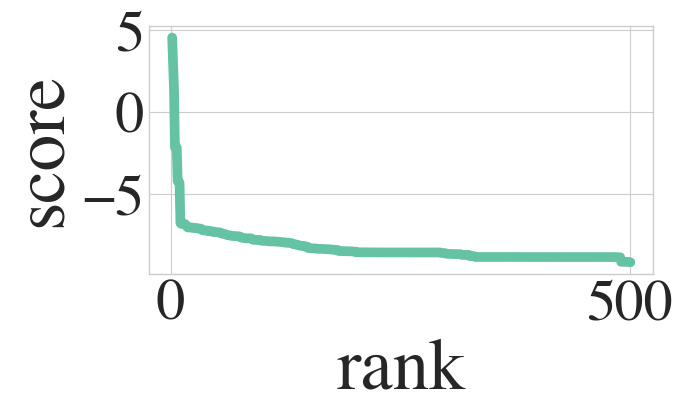

[-9.12560507 -9.12560507 -8.82189339 ...  4.8872987   4.8872987
  4.8872987 ]
[   1    2   55 ... 1999 1995 2000] [   1    2    3 ... 1998 1999 2000]
      relevance    qid gender race                       X  \
1860          0  qid:2    1:1  2:1   3:-1.3674377128057538   
353         203  qid:2    1:0  2:0    3:0.4896122310355855   
1333        346  qid:2    1:0  2:0    3:0.7189498728523163   
905           0  qid:2    1:0  2:0   3:0.16080947266657145   
1289          0  qid:2    1:1  2:0  3:-0.31935877535658674   
...         ...    ...    ...  ...                     ...   
765           0  qid:2    1:0  2:1  3:-0.25224333143362154   
1356          0  qid:2    1:0  2:1  3:0.036142327635091516   
408           0  qid:2    1:1  2:0   3:-0.3147292083833114   
1614          0  qid:2    1:0  2:1  3:0.015200512691435632   
694           0  qid:2    1:0  2:1     3:-1.21139970159791   

                           Y                          meta  
1860   4:-1.3585090930387609    #docid=1879;

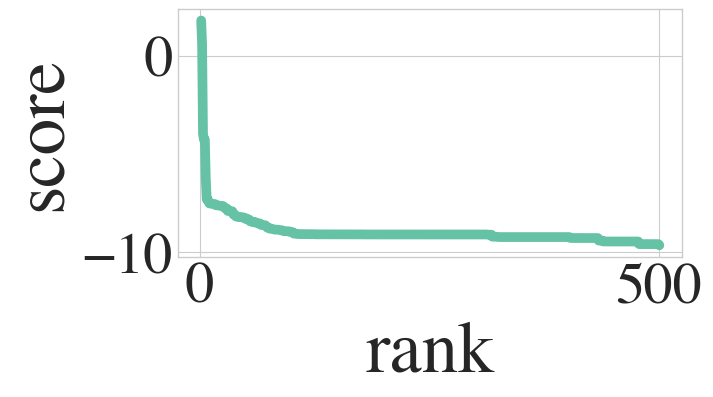

[-9.40000257 -9.40000257 -9.40000257 ...  4.95306605  4.95306605
  4.95306605]
[  19   20   21 ... 1999 1995 2000] [   1    2    3 ... 1998 1999 2000]


In [15]:
for directory in ['bias__bias', 'fair_count__bias']:  # , 'fair_count__fair_count', 'fair_res__bias', 'fair_res__fair_res']:
    # for file in ['R1','R2','R3','R4','R5','R6','R7','R8','R9','R10']:
    for file in ['R10']:
        get_ftr_importance(directory,file)

# Make plots

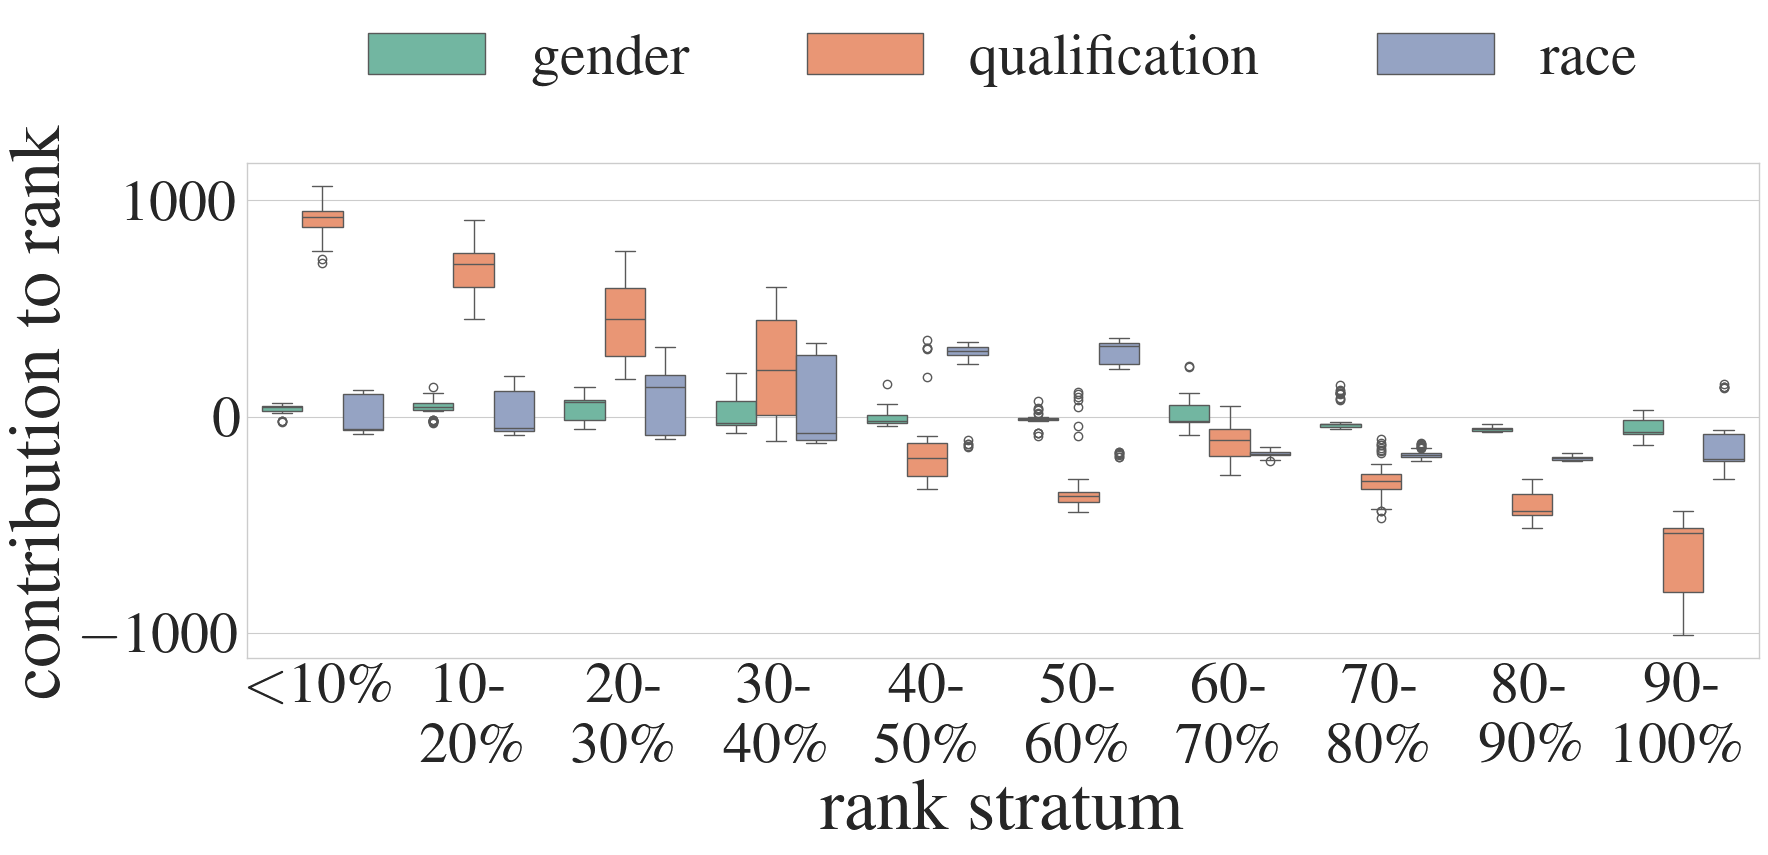

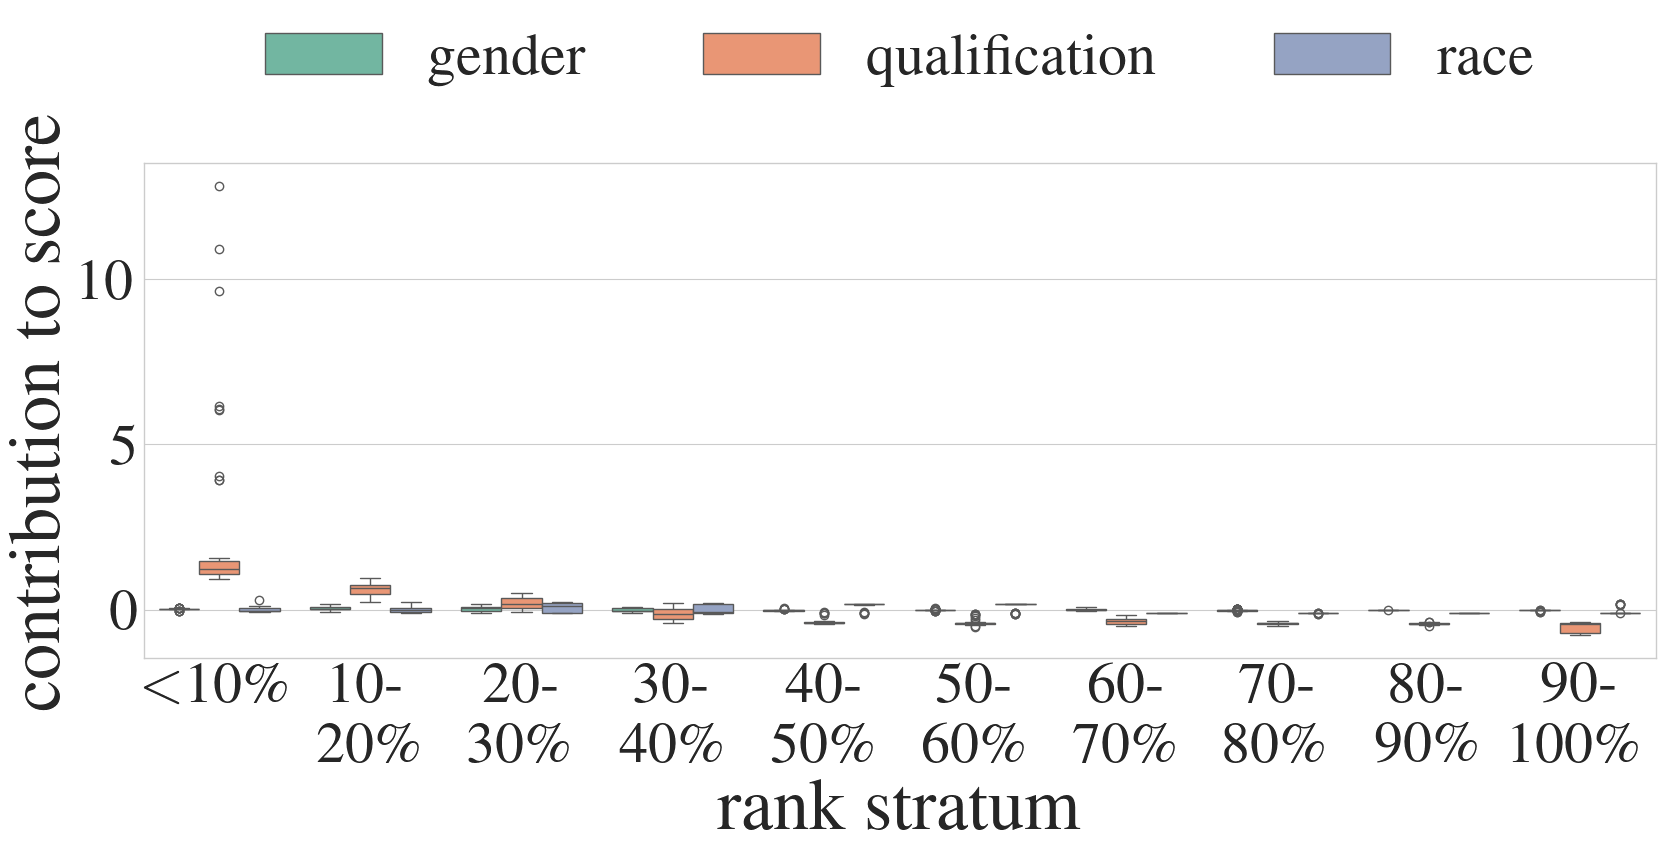

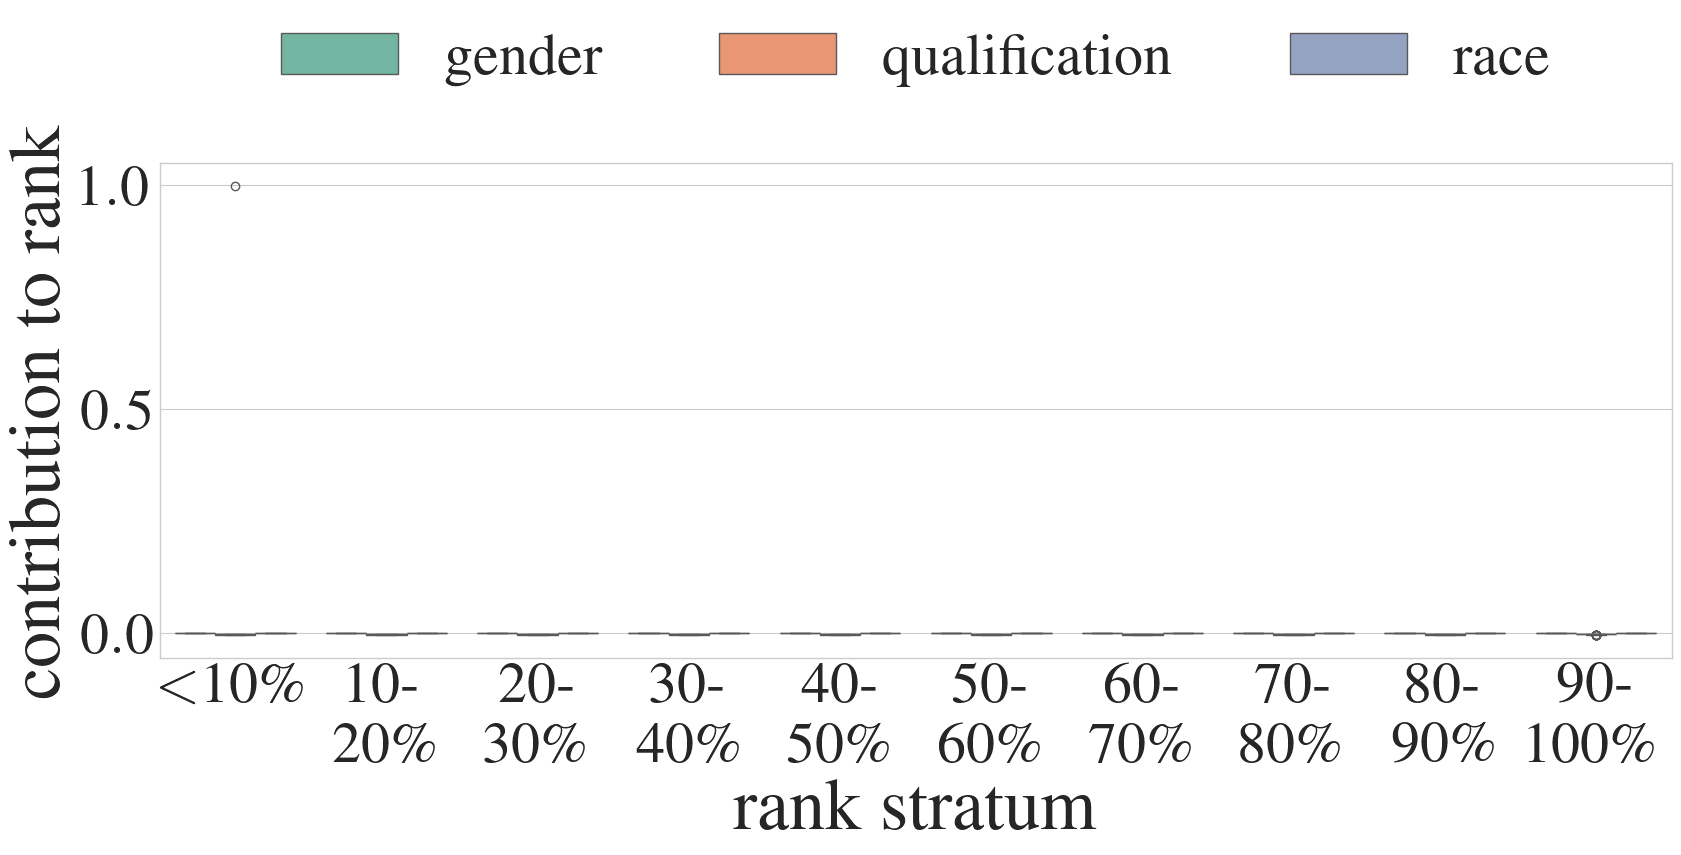

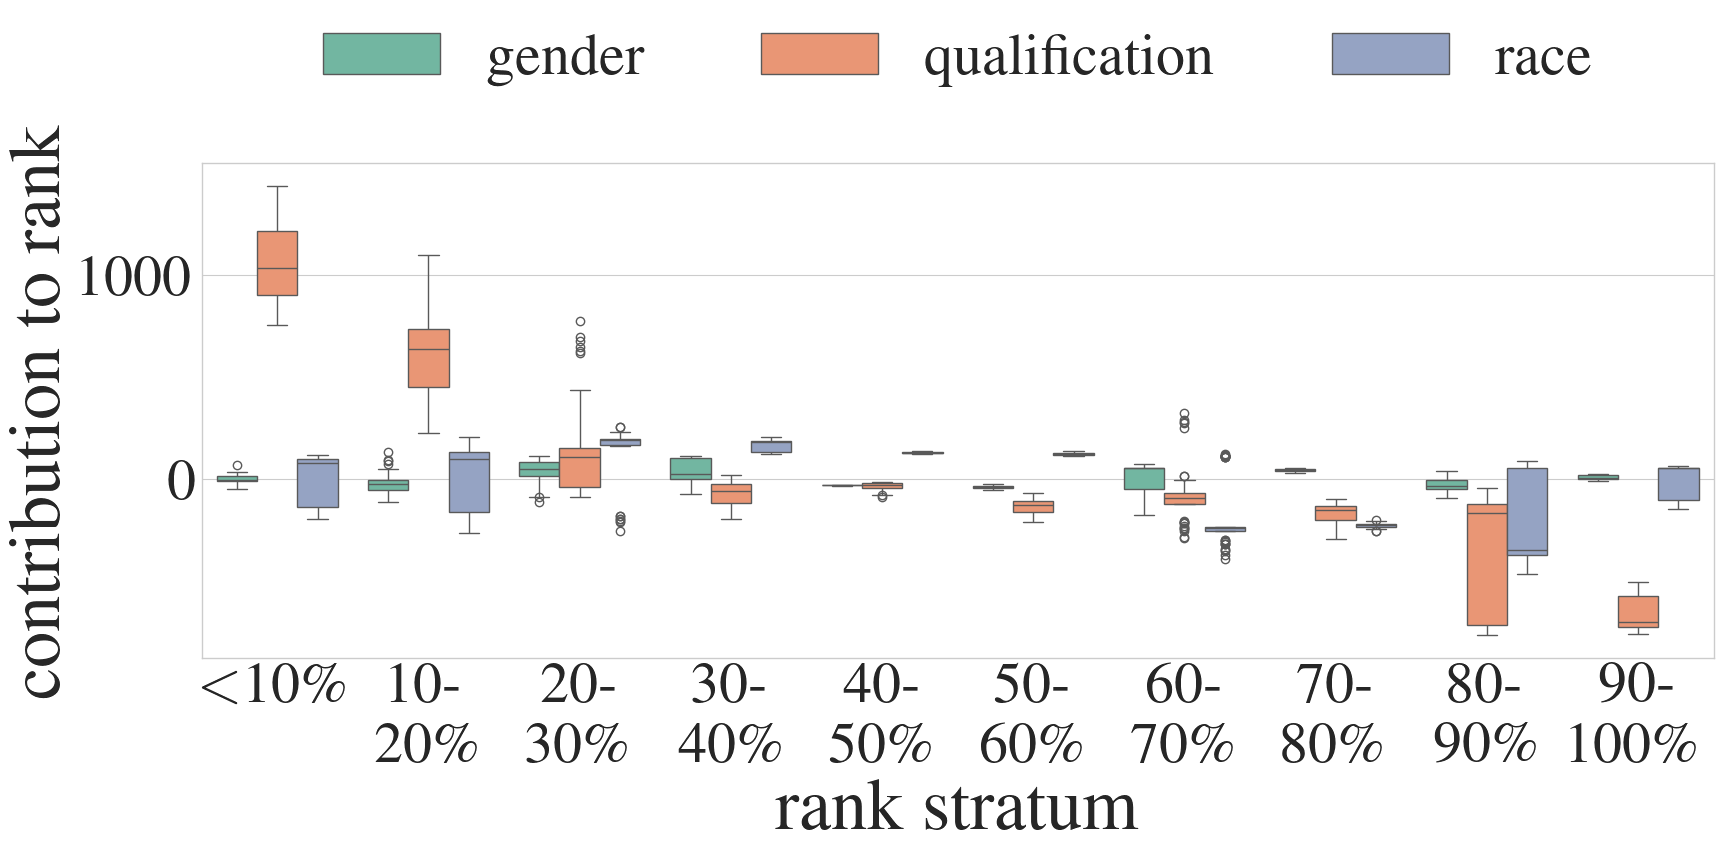

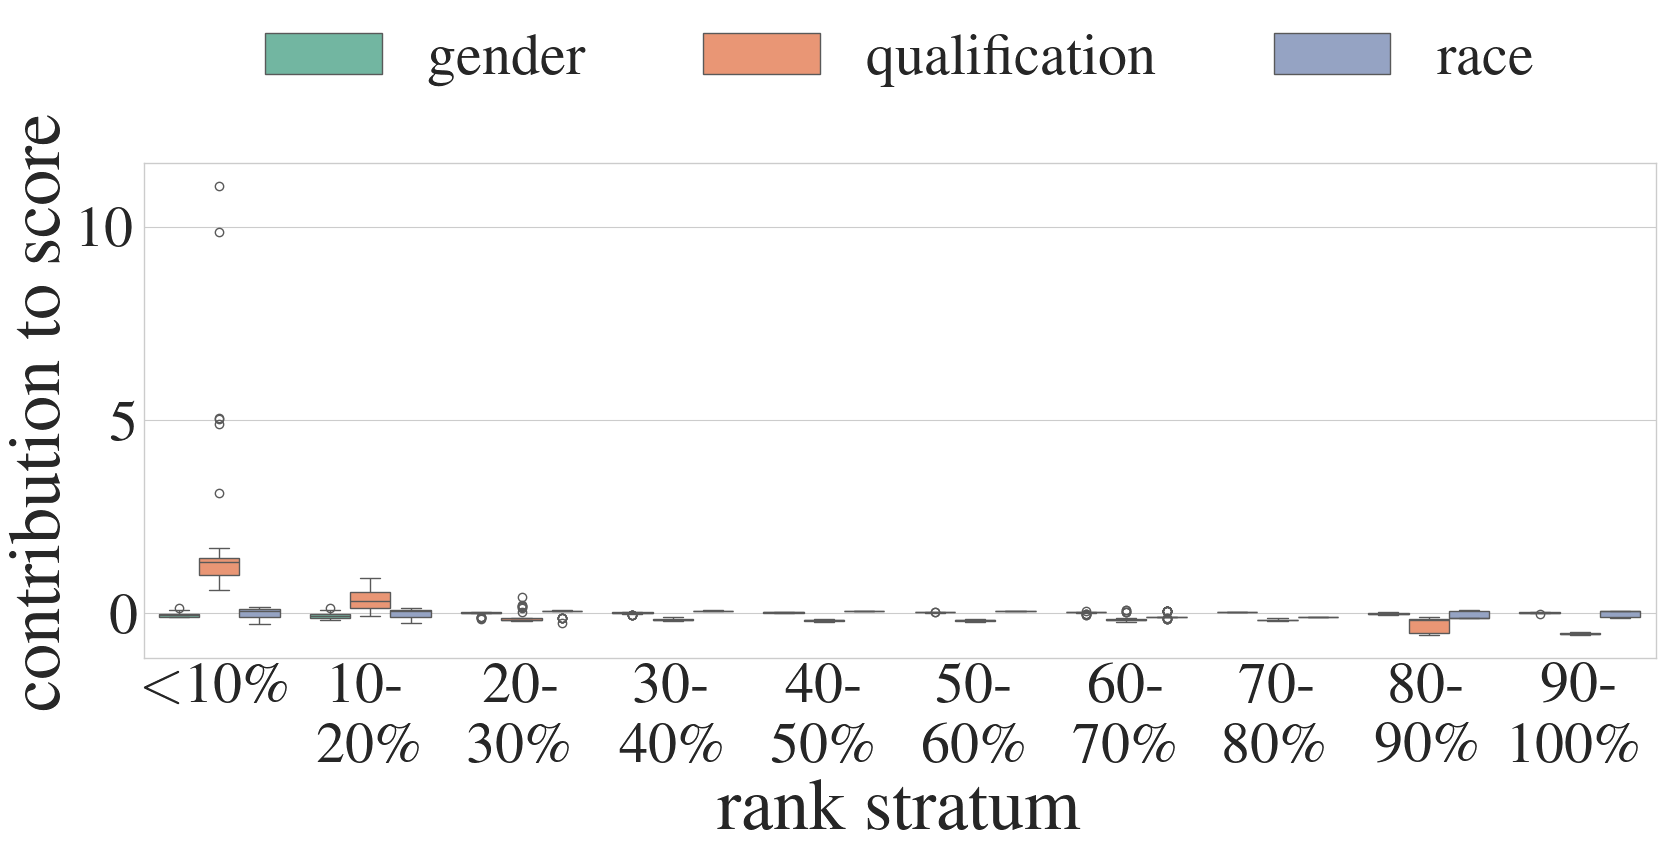

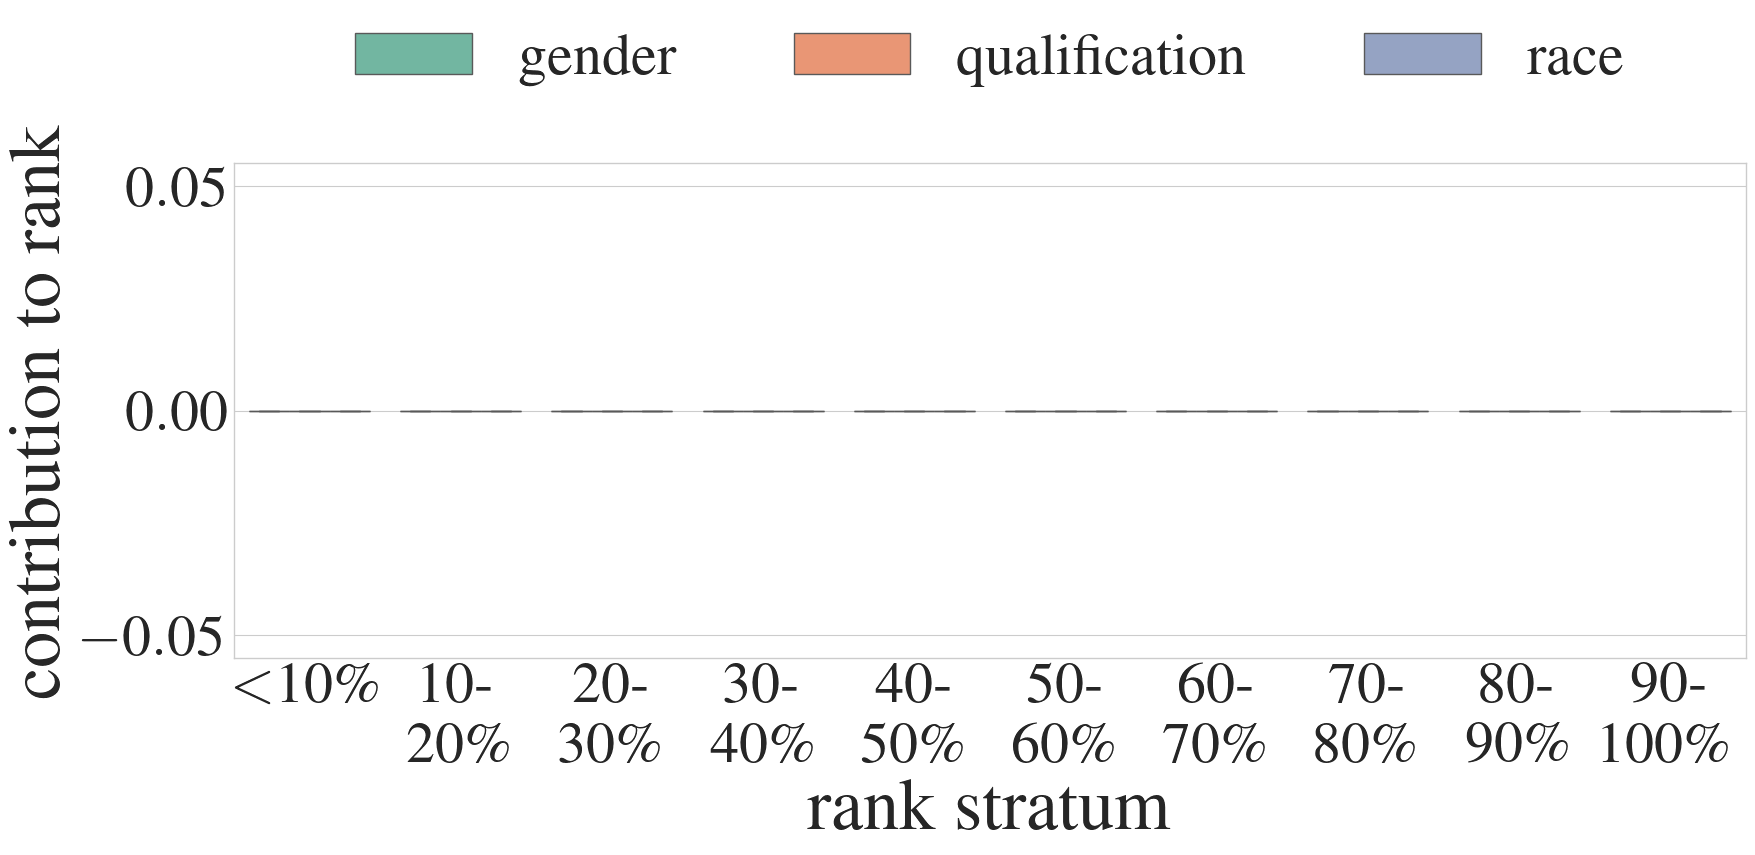

In [11]:
for directory in ['bias__bias', 'fair_count__bias']:  # , 'fair_count__fair_count', 'fair_res__bias', 'fair_res__fair_res']:
    # for file in ['R1','R2','R3','R4','R5','R6','R7','R8','R9','R10']:
    for qoi in ['rankqoi', 'rankscoreqoi', 'topkqoi']:
        buckets = 10
        shapley_values = pd.read_csv(f"{directory}R10_test_ranklib_{qoi}_shapley_values.csv", index_col="Unnamed: 0").rename(columns={"X":"qualification"})

        shapley_values['rank_bucket'] = [
            (
                str(math.floor((rank - 1) / (shapley_values.shape[0] / buckets)) * 10)
                + "-\n"
                + str(math.floor(((rank - 1) / (shapley_values.shape[0] / buckets)) + 1) * 10)
                + "%"
            )
            if math.floor((rank - 1) / (shapley_values.shape[0] / buckets)) != 0
            else "<10%"
            for rank in shapley_values['ranking']
        ]

        shapley_values["Rank Bucket"] = shapley_values["rank_bucket"].str.replace("%", r"\%").str.replace("<", "$<$")
        shapley_values = (
            shapley_values
            .drop(columns=["rank_bucket", "ranking", "score"])
            .melt(id_vars=["Rank Bucket"])
            .rename(columns={"variable": "Feature", "value": "Contribution"})
        )

        shapley_values.sort_values(["Rank Bucket", "Feature"], inplace=True)
        shapley_values["type"] = directory
        shapley_values["experiment"] = file

        # viz
        fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(18, 6), sharey='row')
        graph = sns.boxplot(
            x=shapley_values['Rank Bucket'],
            y=shapley_values['Contribution'],
            hue=shapley_values['Feature'],
            palette="Set2"
        )
        
        contr_to = "score" if "score" in qoi else "rank"
        graph.set_ylabel(f"contribution to {contr_to}")
        graph.set_xlabel("rank stratum")
        sns.move_legend(
            graph, "lower center", bbox_to_anchor=(.5, 1.05), ncol=4, title=None, frameon=False,
        )
    
        plt.savefig(
            f"{directory}R10_test_ranklib_{qoi}.pdf",
            format="pdf",
            bbox_inches="tight",
        )
        # plt.title(directory)
        plt.show()

In [8]:
shapley_all

,Rank Bucket,Feature,Contribution,type,experiment
403,$<$10\%,gender,0.000000,fair_count__bias,R10
429,$<$10\%,gender,0.000000,fair_count__bias,R10
435,$<$10\%,gender,0.000000,fair_count__bias,R10
440,$<$10\%,gender,0.000000,fair_count__bias,R10
441,$<$10\%,gender,0.000000,fair_count__bias,R10
...,...,...,...,...,...
616,90-\n100\%,race,-201.478889,bias__bias,R10
706,90-\n100\%,race,-270.581111,bias__bias,R10
728,90-\n100\%,race,-261.630000,bias__bias,R10
760,90-\n100\%,race,-289.380000,bias__bias,R10


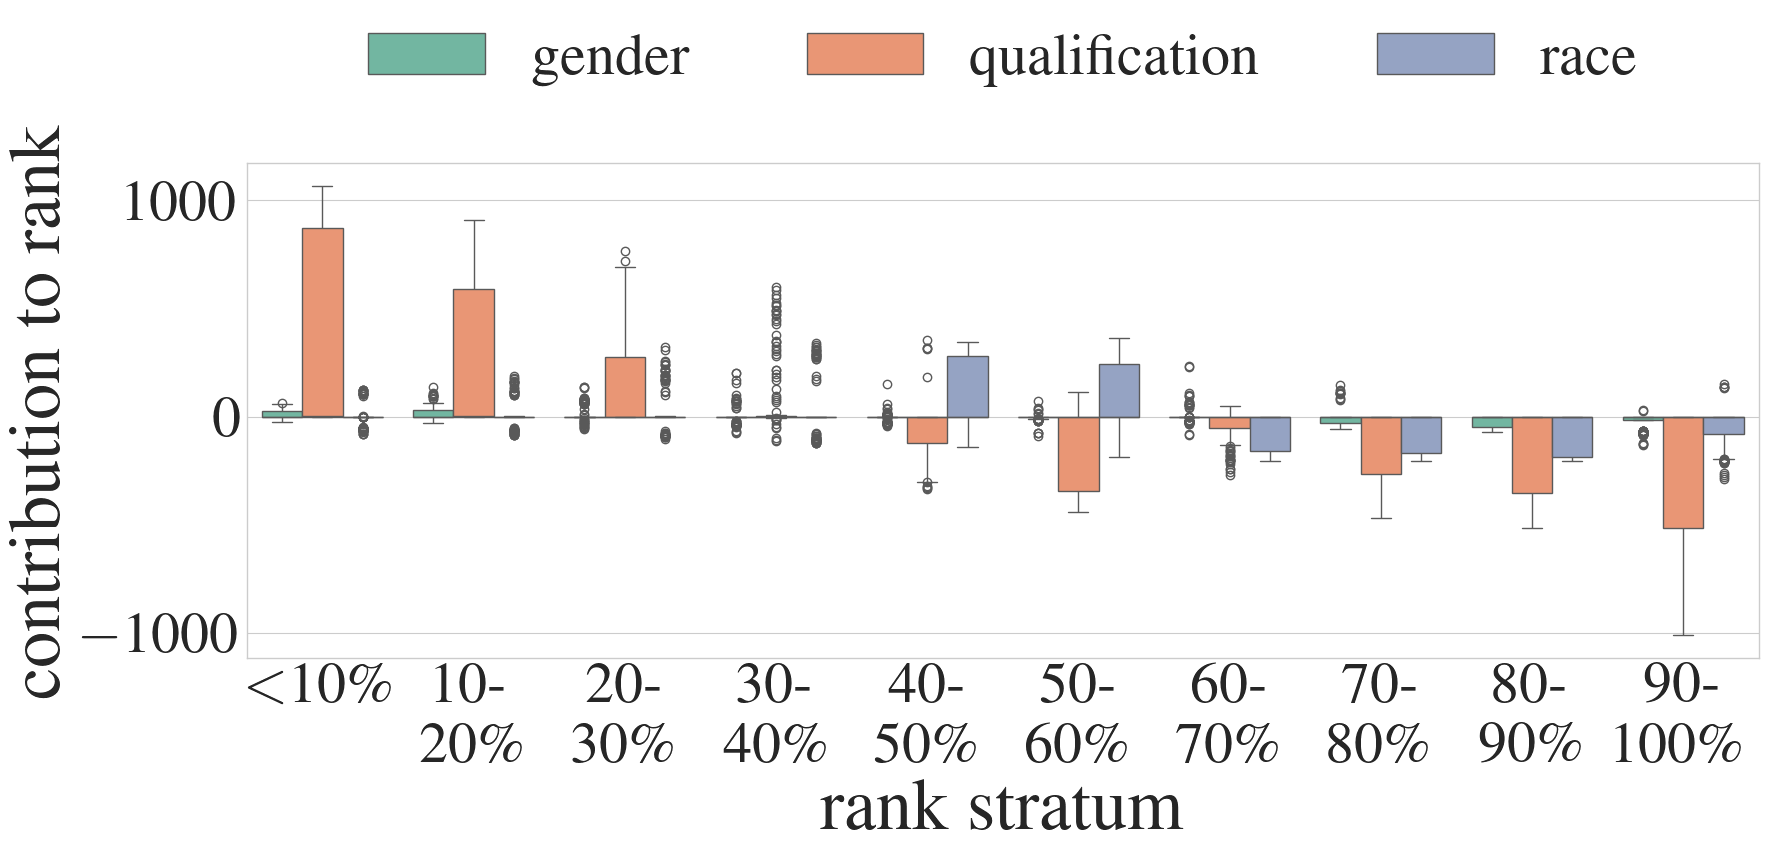

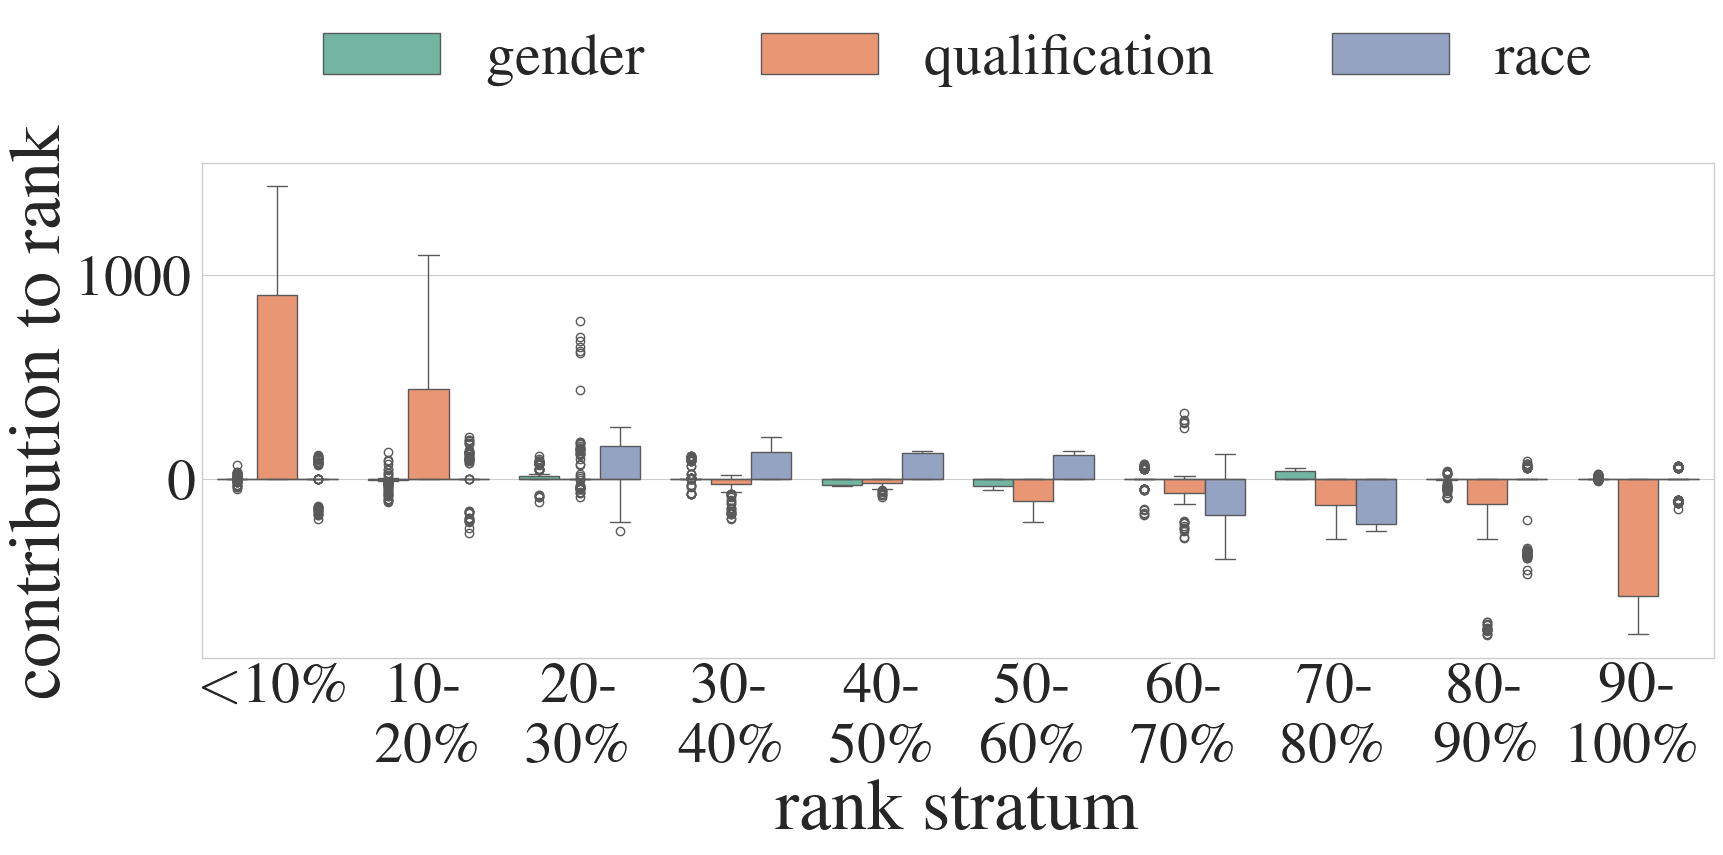

In [9]:
for directory in ['bias__bias', 'fair_count__bias']:  # , 'fair_count__fair_count', 'fair_res__bias', 'fair_res__fair_res']:
    shapley_values = shapley_all[shapley_all["type"] == directory]
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(18, 6), sharey='row')
    graph = sns.boxplot(
        x=shapley_values['Rank Bucket'],
        y=shapley_values['Contribution'],
        hue=shapley_values['Feature'],
        palette="Set2"
    )
    graph.set_ylabel("contribution to rank")
    graph.set_xlabel("rank stratum")
    sns.move_legend(
        graph, "lower center", bbox_to_anchor=(.5, 1.05), ncol=4, title=None, frameon=False,
    )

    plt.savefig(
        f"r10_contrs_rank_sharp_{directory}.pdf",
        format="pdf",
        bbox_inches="tight",
    )
    # plt.title(directory)
    plt.show()